### 2D Example - Main Script

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape

%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

print(loopflopy.__file__)
modules = utils.list_modules(loopflopy)
for module in modules: 
    print(module)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\00105295\Projects\loopflopy\src\loopflopy\__init__.py
dem
disv2disu
flowmodel
flowmodel_routines
geomodel
geomodel2
geomodel_routines
mesh
mesh_routines
observations
project
properties
properties2
spatial
spatial_routines
structuralmodel
surfacerefinement
utils


### 1. Setup Project

In [17]:
# Project setup
name = 'example'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe_name = '../exe/mf6.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe_name)

### 2. Spatial

CHD East  [(385000, 6530000), (385000, 6530001)]
                                      geometry
0  LINESTRING (385000 6530000, 385000 6530001)
CHD West  [(360000, 6535000), (360000, 6535001)]
360000 385000 6535000 6530000


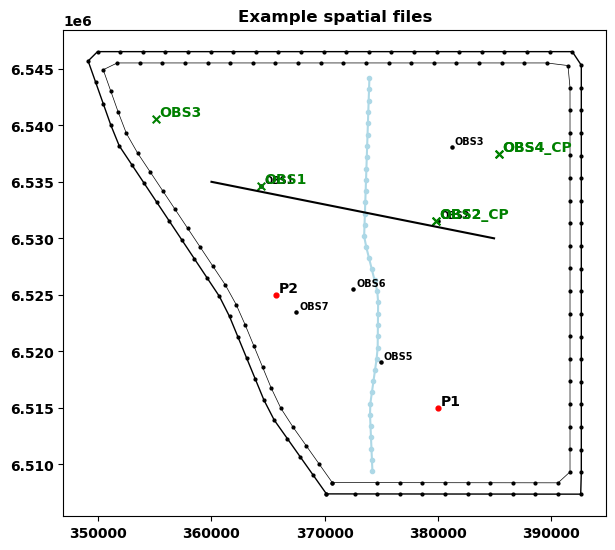

In [18]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = 28350)

model_extent = [(360000, 6535000),(385000, 6530000)]
spatial.model_extent = model_extent

import process_spatial
process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 800, node_spacing = 2000)
process_spatial.obs_bores(spatial)
process_spatial.geo_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.head_boundary(spatial)
process_spatial.faults(spatial)

spatial.x0, spatial.x1 = model_extent[0][0], model_extent[1][0]
spatial.y0, spatial.y1 = model_extent[0][1], model_extent[1][1]
print(spatial.x0, spatial.x1, spatial.y0, spatial.y1)
process_spatial.plot_spatial(spatial, model_extent)

### 3. Structural Model

In [19]:
# Create Structural Model
geodata_fname = '../data/example_data.xlsx'
data_sheetname = 'geo_bores'
strat_sheetname = 'strat'
bbox = [(348000, 6500000, -2000), (400000, 6550000, 500)] #[(x0, y0, z0), (x1, y1, z1)]
from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(bbox, geodata_fname, data_sheetname, strat_sheetname)

import process_structural
process_structural.prepare_strat_column(structuralmodel)
process_structural.prepare_geodata(structuralmodel, spatial)
process_structural.create_structuralmodel(structuralmodel, Fault = False)

structuralmodel.faults = ['Fault']

1.6.14


c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


In [20]:
structuralmodel.strat_names

['Ground', 'TQ', 'Kcok', 'Kwlp', 'Kwlw', 'Kwlm']

In [21]:
structuralmodel.strat

,sequence,unit,lithid,val,R,G,B
0,Ground,Ground,-1,60,255,255,255
1,TQ,TQ,0,5,255,255,0
2,Kcok,Kcok,1,-174,255,204,153
3,Leed,Kwlp,2,-184,204,255,51
4,Leed,Kwlw,3,-569,153,204,0
5,Leed,Kwlm,4,-739,102,153,0


(360000, 6535000)


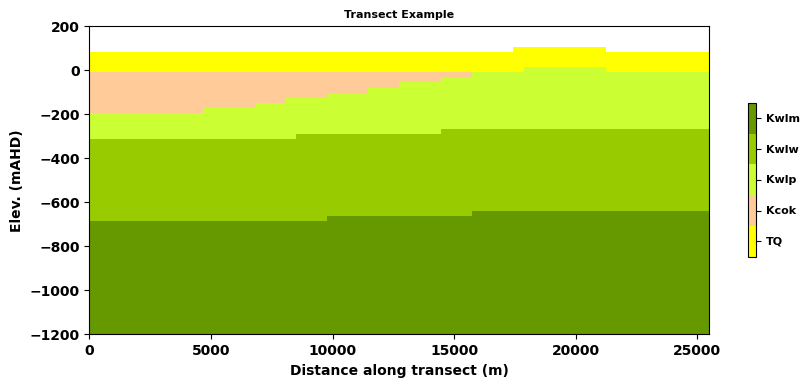

In [22]:
# Plotting of structural model (this is not for the flow model)
start = model_extent[0] 
end = model_extent[1]
z0 = -1200 # just for plotting. Make sure within bbox of structural model
z1 = 200   # just for plotting. Make sure within bbox of structural model
nh, nz = 60, 60 # plotting resolution
print(start)
structuralmodel.plot_xytransect(start = start, end = end, z0 = z0, z1 = z1, nh = nh, nz = nz, title = 'Transect Example')

### 4. Meshing

In [23]:
special_cells = {
                 'chd': ['east', 'west'], 
                 #'wel': ['pumpbores'], 
                 #'obs': ['obsbores'], 
                 }

# Create mesh object
from loopflopy.mesh import Mesh
mesh = Mesh(plangrid = 'transect', special_cells = special_cells) # special cells to identify as arguements 

### FOR FLOW MODEL!!! ####
mesh.ncol = 40
mesh.nrow = 1
mesh.delc = 100 # Width of transect (does not matter for 1D model)
mesh.ncpl = mesh.nrow * mesh.ncol


In [24]:
print(spatial.x0, spatial.y0)
print(spatial.x1, spatial.y1)
#mesh.create_mesh(project, spatial)
mesh.create_mesh_transect(spatial.crs, 
                          spatial.x0, spatial.x1, spatial.y0, spatial.y1, 
                          mesh.ncol, mesh.delc)
print('number of cells in plan = ', mesh.ncpl)
mesh.locate_special_cells(spatial)
mesh.chd_west_cells

360000 6535000
385000 6530000

Transect length: 25495.097567963923
x0 =  360000  ,y0 =  6535000
x1 =  385000  ,y1 =  6530000
angrot  -11.309932474020213
ncol =  40
number of cells in plan =  40
Group =  chd ['east', 'west']
flag = 1
chd_east_cells [39]
chd_west_cells [0]


c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\flopy\utils\gridintersect.py:936: DeprecationWarning: In the future this function will return a dataframe by default. Set dataframe=True to adopt future behavior and silence this warning. Set dataframe=False to silence this warning and maintain old behavior
  warnings.warn(
c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\flopy\utils\gridintersect.py:936: DeprecationWarning: In the future this function will return a dataframe by default. Set dataframe=True to adopt future behavior and silence this warning. Set dataframe=False to silence this warning and maintain old behavior
  warnings.warn(


array([0])

(np.float64(358749.0194193243),
 np.float64(386270.59219418955),
 np.float64(6529745.097096622),
 np.float64(6535352.9609709475))

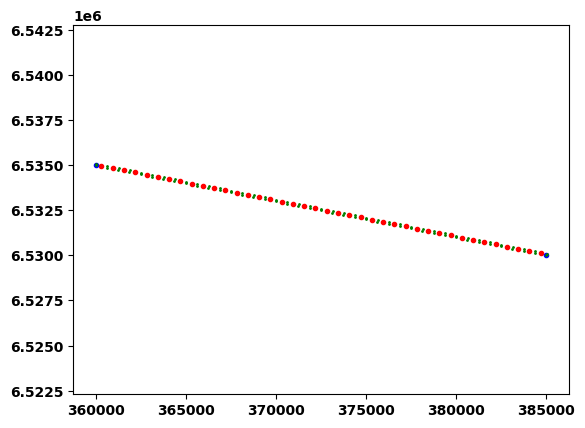

In [25]:
# Plot of cell centres (red), vertices (green) and transect (blue)
plt.plot(mesh.xcenters, mesh.ycenters, 'ro', ms= 3.)
plt.plot(spatial.x0, spatial.y0, 'bo', ms = 3.)
plt.plot(spatial.x1, spatial.y1, 'bo', ms = 3.)
for ivert in mesh.vertices:
    i, x, y = ivert
    plt.plot(x, y, 'go', ms = 1.)
    #plt.text(x, y, str(i))
plt.axis('equal')

### 5. Geomodel

In [26]:
# Set up Geomodel (lithological block model of cells)
scenario = 'example'
vertgrid = 'con' # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}
z0, z1 = -1200, 200
surface = np.ones((mesh.ncol))*z1 # This is the top surface of the model

from loopflopy.geomodel import Geomodel

geomodel = Geomodel(scenario, 
                    mesh, 
                    structuralmodel, 
                    vertgrid, 
                    z0, z1, 
                    transect = True,
                    #nlay = 30 # only used for voxel - number of layers
                    ) 
geomodel.evaluate_structuralmodel(
                                  res = 5 # CON / CON2 - vertical resolution of geological layers (m)
                                  )
geomodel.create_model_layers(
                             surface,                              
                             max_thick = [50, 100, 100, 100, 100], # CON2  
                             nlg = None, # number of geological layers - if None, will extend down to z0
                             nls = 2, # Number of sublayers CON/CON2    
                             )


Creating Geomodel for  example  ...

0. Creating xyz array... 
   Time taken Block 0 (creating xyz array) =  0.170287

1. Evaluating structural model... 
   len(xyz) =  11200
   Time taken Block 1 (Evaluate model) =  0.108623

2. Creating geo model layers...
   dz calculated from z0, z1 and nlay =  5.0
   nlay =  280
   ncpl =  40
   nlg number of geo layers =  5
   botm_geo_shape (5, 40)
   idomain_geo unique values and counts:  (array([0., 1.]), array([ 13, 187]))
   Note: Geomodel bottom = flat at z0 (not bottom of geo layer)
   idomain_geo unique values and counts:  (array([0., 1.]), array([ 13, 187]))
   Time taken Block 2 (Create geological model layers) 0.0

3. Creating flow model layers...
   number of geological layers in geomodel =  5
   Time taken Block 3 create flow model layers =  0.0

4. Calculating cellids and gradients...
   Time taken Block 4 gradients=  0.023634


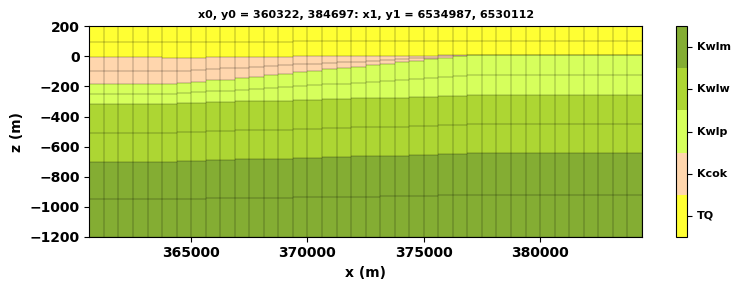

In [27]:
geomodel.geomodel_transect_lith(figsize = (8,3))

In [28]:
# FILL CELL PROPERTIES
props = pd.read_excel('../data/example_data.xlsx', sheet_name = 'properties')
props = props.drop(index=[0]).reset_index()#inplace=True) # drop first row as it is ground
geomodel.hk_perlay = props.hk.tolist()
geomodel.vk_perlay = props.vk.tolist()
geomodel.ss_perlay = props.ss.tolist()
geomodel.sy_perlay = props.sy.tolist()
geomodel.iconvert_perlay = props.iconvert.tolist()
geomodel.fill_cell_properties(mesh)
props


5. Filling cell properties...
   ang1 shape  (10, 40)
   angle1 shape  (374,)
   Time taken Block 5 Fill cell properties =  0.0


,index,unit,hk,vk,ss,sy,iconvert
0,1,TQ,1.0,0.10,0.0001,0.1,1.0
1,2,Kcok,0.1,0.01,0.0001,0.1,0.0
2,3,Kwlp,1.0,0.10,0.0001,0.1,0.0
3,4,Kwlw,5.0,0.50,0.0001,0.1,0.0
4,5,Kwlm,10.0,1.00,0.0001,0.1,0.0


### 6. Prepare Data for Flowmodel

In [29]:
from process_data import Data
data = Data()

data.process_ic()
data.process_rch(geomodel, mesh)
data.process_chd(spatial, geomodel, mesh)

[0]
[39]


In [30]:
import process_observations
obs_df = process_observations.make_obs_df(mesh, geomodel,  # Create a df of fake observation points
                                          nobs_x = 5,      # along transect
                                          nobs_z = 3)      # vertical
obs_gdf = process_observations.make_obs_gdf(obs_df, geomodel, mesh, spatial)

15
[[np.float64(364072.3058067569), np.float64(6534236.529033785), np.float64(-150.0)], [np.float64(364072.3058067569), np.float64(6534236.529033785), np.float64(-500.0)], [np.float64(364072.3058067569), np.float64(6534236.529033785), np.float64(-850.0)], [np.float64(368447.3058067569), np.float64(6533361.529033785), np.float64(-150.0)], [np.float64(368447.3058067569), np.float64(6533361.529033785), np.float64(-500.0)], [np.float64(368447.3058067569), np.float64(6533361.529033785), np.float64(-850.0)], [np.float64(372197.3058067569), np.float64(6532611.529033785), np.float64(-150.0)], [np.float64(372197.3058067569), np.float64(6532611.529033785), np.float64(-500.0)], [np.float64(372197.3058067569), np.float64(6532611.529033785), np.float64(-850.0)], [np.float64(376572.3058067569), np.float64(6531736.529033785), np.float64(-150.0)], [np.float64(376572.3058067569), np.float64(6531736.529033785), np.float64(-500.0)], [np.float64(376572.3058067569), np.float64(6531736.529033785), np.float6

In [31]:
# Make package arrays
from loopflopy.observations import Observations
observations = Observations(obs_gdf)
observations.make_recarray()
# observations.gdf # Unhash this line to show the spreadhsteet of observation points

### 8. Create and run steady-state flow model

In [32]:
scenario = 'steadymodel'
from loopflopy.flowmodel import Flowmodel
fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)

# Write and run flow model files
sim, gwf = fm.write_flowmodel(chd = True, wel = False, obs = True, rch = True)
fm.run_flowmodel(sim)

Writing simulation and gwf for  steadymodel  ...
    xt3d =  True
    staggered =  True
    transient =  False
    mf6 executable expected:  ../exe/mf6.exe
Time taken to write flow model =  0.284333
Running simulation for  steadymodel  ...
Model success =  True
run_time =  0.511651
['DISU', 'NPF', 'IC', 'STO', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 374)
Type bud  <class 'flopy.utils.binaryfile.CellBudgetFile'>


In [33]:
#utils.print_object_details(fm)

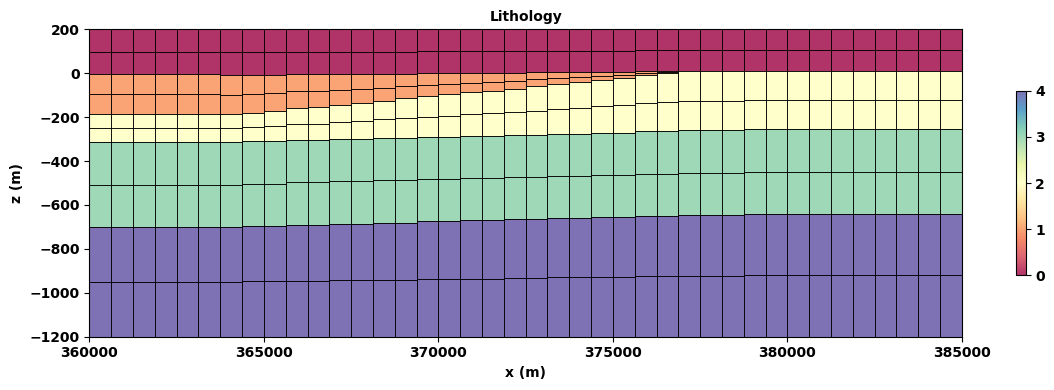

In [34]:
fm.plot_transect(mesh, spatial,                
                 geomodel, 'lith',
                 title = 'Lithology',
                 grid = True,)

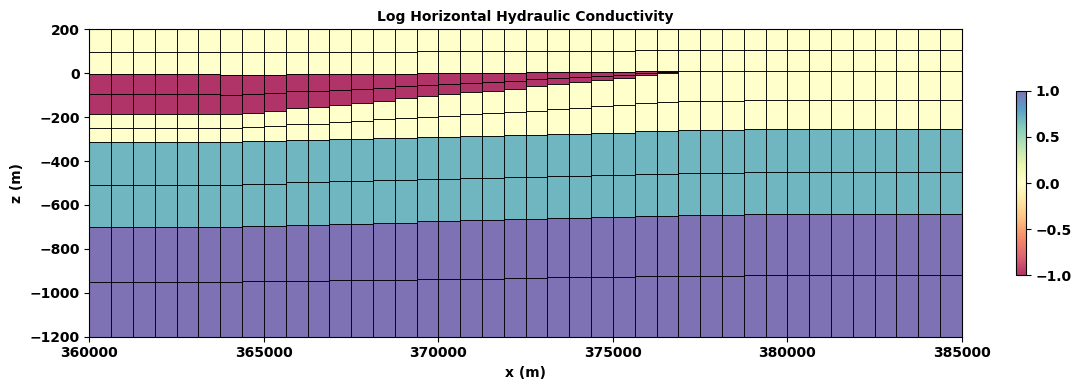

In [35]:
fm.plot_transect(mesh, spatial,                
                 geomodel, 'logk11',
                 title = 'Log Horizontal Hydraulic Conductivity',
                 grid = True,)

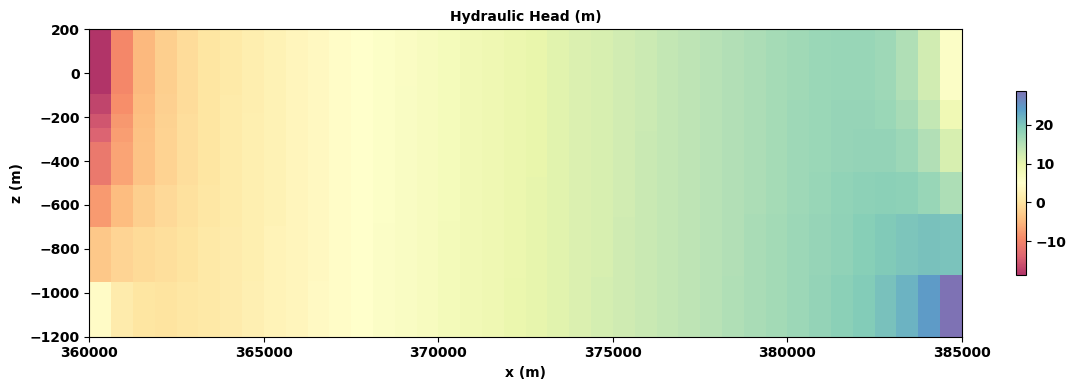

In [36]:
fm.plot_transect(mesh, spatial, geomodel, 
                 title = 'Hydraulic Head (m)',
                 array = 'head', 
                 grid = False, 
                 contours = False,
                 levels = np.arange(0, 40, 5), # Only need to include if plotting contours
                 vectors = False,
                 normalize = False,
                 kstep = 20, hstep = 3, # IF VECTORS = TRUE, need this line! spacing vertical, horizontal
                 #vmin = 10, vmax = 25 # can change scale of color
                 )     

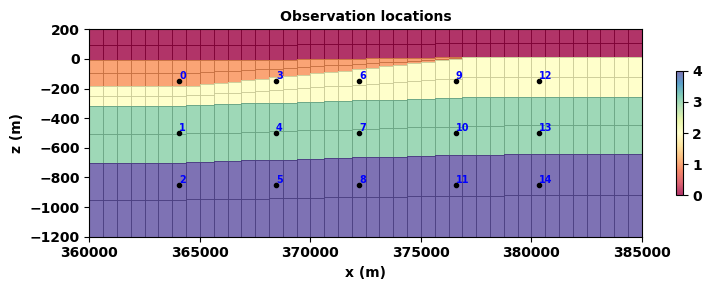

In [37]:
# Plot Observation Points
x0, x1 = spatial.x0, spatial.x1
y0, y1 = spatial.y0, spatial.y1
z0, z1 = geomodel.z0, geomodel.z1

fig = plt.figure(figsize = (8,3))
ax = plt.subplot(111)
ax.set_title('Observation locations', size = 10)
xsect = flopy.plot.PlotCrossSection(model=fm.gwf, line={"line": [(x0, y0),(x1, y1)]}, 
                                    extent = [x0, x1, z0, z1], geographic_coords=True)
xsect.plot_grid(lw = 0.5, color = 'black') 
csa = xsect.plot_array(a = geomodel.lith, cmap = 'Spectral', alpha=0.8)#, vmin = vmin, vmax = vmax)

# Plot and label observation points
ax.plot(observations.gdf.x, observations.gdf.z, 'o', color='black', markersize=3)
for i, row in observations.gdf.iterrows():
    ax.text(row.x, row.z, str(row.name), fontsize=7, color='blue', ha='left', va='bottom')

ax.set_xlabel('x (m)', size = 10)
ax.set_ylabel('z (m)', size = 10)
ax.set_ylim([z0, z1])
ax.set_title('Observation locations', size = 10)
plt.colorbar(csa, shrink = 0.6)
plt.tight_layout()  
plt.savefig('../figures/transect_with_obs.png')
plt.show() 

In [38]:
obj = fm
methods = [func for func in dir(obj) if callable(getattr(obj, func)) and not func.startswith("__")]
print("Methods in the class:  ",methods)
attributes = [attr for attr in dir(obj) if not callable(getattr(obj, attr)) and not attr.startswith("__")]
print("\nAttributes in the class:  ", attributes)

#for attribute, value in flowmodel.data.__dict__.items(): print(attribute)

Methods in the class:   ['get_watertable', 'plot_particles', 'plot_plan', 'plot_transect', 'plot_watertable', 'prepare_particles', 'run_flowmodel', 'run_modpath', 'write_flowmodel']

Attributes in the class:   ['chd', 'chdflow', 'data', 'disu_gridprops', 'evt', 'geomodel', 'ghb', 'gwf', 'head', 'lith', 'logk11', 'logk33', 'mesh', 'newtonoptions', 'obs', 'obsdata', 'observations', 'project', 'qx', 'qy', 'qz', 'rch', 'runtime', 'scenario', 'spd', 'staggered', 'transient', 'wel', 'xt3d', 'zbud']
